In [1]:
import pandas 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import requests
import gzip
import re
import math
from datetime import datetime 

### How much does heat rate change over time?
- To determine how much heat rate impacts the merit order 
- Production cost = heat rate * fuel price + variable operations and maintenance cost (VOM)

In [168]:
df_orispl_unit = pandas.read_csv('/home/amy/simple_dispatch/weekly/PJM_df.csv')
heat_rate_df = df_orispl_unit.copy(deep=True)

In [169]:
# Keep only heat rate columns 
cols = ['orispl_unit', 'fuel_type']
for i in range (1, 53):
    cols.append("heat_rate" + str(i))

heat_rate_df = df_orispl_unit[cols]

#fill in NA values
for i in range (1, 53):
    colName = 'heat_rate' + str(i)
    heat_rate_df[colName] = heat_rate_df.apply(
    lambda row: row['heat_rate' + str(i-1)] if np.isnan(row[colName]) else row[colName],
    axis=1
)

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [170]:
heat_rate_gas = heat_rate_df.loc[heat_rate_df['fuel_type'] == 'gas'].drop(['fuel_type'], axis=1)
heat_rate_coal = heat_rate_df.loc[heat_rate_df['fuel_type'] == 'coal'].drop(['fuel_type'], axis=1)
heat_rate_oil = heat_rate_df.loc[heat_rate_df['fuel_type'] == 'oil'].drop(['fuel_type'], axis=1)

**Gas Plants**

In [171]:
heat_rate_gas = heat_rate_gas.T
heat_rate_gas = heat_rate_gas.rename(columns=heat_rate_gas.iloc[0]).drop(heat_rate_gas.index[0])

# Print table summarizing heat rate of different plants  
df_summary = pandas.DataFrame()
df_summary['mean'] = heat_rate_gas.mean()
df_summary['median'] = heat_rate_gas.median()
df_summary['max'] = heat_rate_gas.max()
df_summary['min'] = heat_rate_gas.min()
df_summary['std'] = heat_rate_gas.std()

df_summary

,mean,median,max,min,std
10030_2,9.373559,9.282000,9.910256,9.097826,2.563207e-01
10030_3,5.180052,8.724000,9.910256,0.000000,4.487891e+00
2840_3,11.410205,11.694444,12.422222,8.168230,8.650146e-01
55247_CT1,9.642967,9.017751,12.230263,8.551803,1.364438e+00
55247_CT2,9.787911,9.040503,12.907792,8.551803,1.553685e+00
...,...,...,...,...,...
1553_3,12.543790,12.543790,12.543790,12.543790,5.381063e-15
1554_1,11.914836,11.914836,11.914836,11.914836,0.000000e+00
56963_E101,17.097840,17.097840,17.097840,17.097840,1.434950e-14
56963_E102,19.329064,19.329064,19.329064,19.329064,0.000000e+00


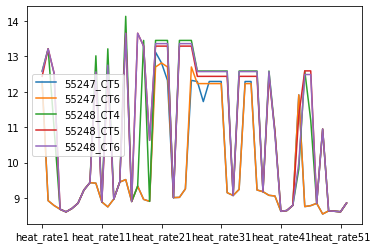

In [173]:
# Graph heat rates
df_graph1 = heat_rate_gas.iloc[:,7:12].copy()

df_graph1.plot()

In [174]:
# Convert heat rate into ranking

heat_rate_gas = heat_rate_gas.T
df_rank = heat_rate_gas.copy(deep=True)
cols = df_rank.columns
df_rank[cols] = df_rank[cols].rank().astype(int)
df_rank

,heat_rate1,heat_rate2,heat_rate3,heat_rate4,heat_rate5,heat_rate6,heat_rate7,heat_rate8,heat_rate9,heat_rate10,...,heat_rate43,heat_rate44,heat_rate45,heat_rate46,heat_rate47,heat_rate48,heat_rate49,heat_rate50,heat_rate51,heat_rate52
10030_2,15,17,32,41,41,41,41,11,11,24,...,37,30,39,33,45,21,46,46,46,49
10030_3,14,1,11,40,1,1,1,10,1,24,...,36,1,29,26,1,1,1,1,1,17
2840_3,20,21,9,44,47,43,46,49,47,34,...,41,39,50,55,57,56,55,61,62,60
55247_CT1,37,13,14,24,25,18,25,26,26,30,...,30,28,32,29,30,17,37,37,37,34
55247_CT2,44,13,14,24,25,18,25,26,26,30,...,30,28,32,29,30,17,37,37,37,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553_3,47,37,61,63,64,61,63,55,64,59,...,58,49,56,63,63,64,62,64,64,64
1554_1,35,32,39,50,60,57,59,53,62,48,...,52,44,52,59,59,58,57,62,61,62
56963_E101,69,70,70,70,70,70,70,67,70,70,...,70,68,70,70,70,70,70,70,70,70
56963_E102,72,72,72,72,72,72,72,72,72,72,...,72,72,72,72,72,72,72,72,72,72


**Coal Plants**

In [60]:
heat_rate_coal = heat_rate_coal.T
heat_rate_coal = heat_rate_coal.rename(columns=heat_rate_coal.iloc[0]).drop(heat_rate_coal.index[0])

# Heat rate should be rows 
df_summary = pandas.DataFrame()
df_summary['mean'] = heat_rate_coal.mean()
df_summary['median'] = heat_rate_coal.median()
df_summary['max'] = heat_rate_coal.max()
df_summary['min'] = heat_rate_coal.min()
df_summary['std'] = heat_rate_coal.std()
df_summary

Summary of Coal Plants


,mean,median,max,min,std
1040_1,5.644147,8.761463,11.504545,0.000000,4.760915e+00
1040_2,5.679425,8.761463,11.468889,0.000000,4.793327e+00
2828_1,7.213804,8.646243,9.097826,0.000000,3.335167e+00
2828_2,8.298176,8.842250,9.291904,0.000000,2.081785e+00
2828_3,8.786646,8.887395,13.017268,0.000000,2.485479e+00
...,...,...,...,...,...
3775_1,10.161482,10.161482,10.161482,10.161482,3.587375e-15
3775_2,10.525783,10.525783,10.525783,10.525783,1.793688e-15
3775_3,10.194992,10.194992,10.194992,10.194992,0.000000e+00
3776_6,9.817160,9.817160,9.817160,9.817160,8.968438e-15


In [61]:
heat_rate_oil = heat_rate_oil.T
heat_rate_oil = heat_rate_oil.rename(columns=heat_rate_oil.iloc[0]).drop(heat_rate_oil.index[0])

# Heat rate should be rows 
df_summary = pandas.DataFrame()
df_summary['mean'] = heat_rate_oil.mean()
df_summary['median'] = heat_rate_oil.median()
df_summary['max'] = heat_rate_oil.max()
df_summary['min'] = heat_rate_oil.min()
df_summary['std'] = heat_rate_oil.std()
print("Summary of Oil Plants")
df_summary

Summary of Oil Plants


,mean,median,max,min,std
593_5,11.242716,11.355140,17.355159,6.545802,2.521792e+00
7153_5,11.729858,11.800110,12.547826,8.833209,4.762064e-01
7153_6,11.681529,11.753159,12.547826,8.833209,4.734058e-01
7153_7,11.744909,11.798162,12.122414,9.785556,3.631640e-01
1355_8,5.447266,5.447266,5.447266,5.447266,2.690531e-15
1355_9,4.212298,4.212298,4.212298,4.212298,4.484219e-15
1554_4,13.354199,13.354199,13.354199,13.354199,1.076213e-14
3161_4,18.721401,18.721401,18.721401,18.721401,2.152425e-14


In [35]:
# Transpose so each plant is a column
heat_rate_df = heat_rate_df.T
heat_rate_df = heat_rate_df.rename(columns=heat_rate_df.iloc[0]).drop(heat_rate_df.index[0])

# Heat rate should be rows 
df_summary = pandas.DataFrame()
df_summary['mean'] = heat_rate_df.drop(['fuel_type']).mean()
df_summary['median'] = heat_rate_df.drop(['fuel_type']).median()
df_summary['max'] = heat_rate_df.drop(['fuel_type']).max()
df_summary['min'] = heat_rate_df.drop(['fuel_type']).min()
df_summary['std'] = heat_rate_df.drop(['fuel_type']).std()
df_summary

,mean,median,max,min,std
10030_2,9.373559,9.282000,9.910256,9.097826,2.563207e-01
10030_3,5.180052,8.724000,9.910256,0.000000,4.487891e+00
1040_1,5.644147,8.761463,11.504545,0.000000,4.760915e+00
1040_2,5.679425,8.761463,11.468889,0.000000,4.793327e+00
2828_1,7.213804,8.646243,9.097826,0.000000,3.335167e+00
...,...,...,...,...,...
3775_3,10.194992,10.194992,10.194992,10.194992,0.000000e+00
3776_6,9.817160,9.817160,9.817160,9.817160,8.968438e-15
10771_1,7.339164,7.339164,7.339164,7.339164,0.000000e+00
10774_1,7.597499,7.597499,7.597499,7.597499,0.000000e+00


## Assess relationship of heat rate of a single plant and other variables 

In [62]:
df_orispl_unit = pandas.read_csv('/home/amy/simple_dispatch/weekly/PJM_cems_df.csv')

plant = df_data.copy(deep=True)
cols = ['date', 'hour', 'mwh', 'heat_rate', 'co2', 'so2', 'nox', 'orispl_unit']
plant = plant[cols]
plant['date'] = pandas.to_datetime(plant['date'])
plant['month'] = plant['date'].dt.month
plant['day'] = plant['date'].dt.day

# Remove outlier heat rate (defined as greater than 30)
plant = plant.loc[plant['heat_rate'] <= 30] 

#plant_demand = plant_info.merge(demand, on=['date', 'orispl_unit'])
plant = plant.groupby(['date', 'orispl_unit']).mean().reset_index()

### Plant 1 - Gas

#### Heat Rate

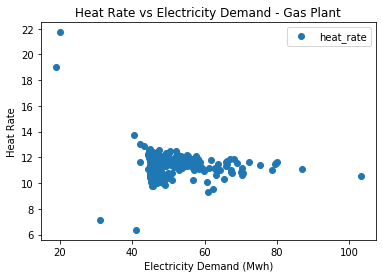

In [148]:
plant1 = plant[plant['orispl_unit']=='2840_3'] 

plant1.plot(x='mwh', y='heat_rate', style='o')  
plt.title('Heat Rate vs Electricity Demand - Gas Plant')  
plt.xlabel('Electricity Demand (Mwh)')
plt.ylabel('Heat Rate')

plt.show()

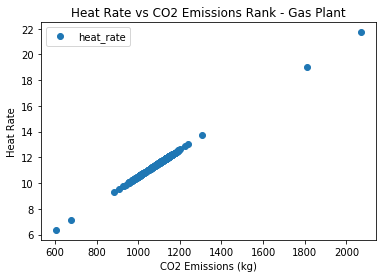

In [149]:
plant1.plot(x='co2', y='heat_rate', style='o')  
plt.title('Heat Rate vs CO2 Emissions Rank - Gas Plant')  
plt.xlabel('CO2 Emissions (kg)')
plt.ylabel('Heat Rate')

plt.show()

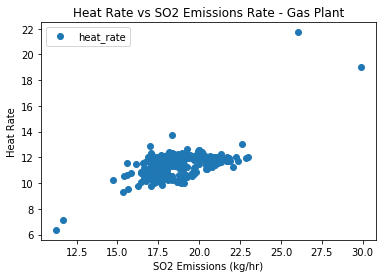

In [150]:
plant1.plot(x='so2', y='heat_rate', style='o')  
plt.title('Heat Rate vs SO2 Emissions Rate - Gas Plant')  
plt.xlabel('SO2 Emissions (kg/hr)')
plt.ylabel('Heat Rate')

plt.show()

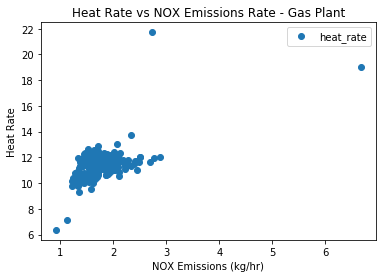

In [151]:
plant1.plot(x='nox', y='heat_rate', style='o')  
plt.title('Heat Rate vs NOX Emissions Rate - Gas Plant')  
plt.xlabel('NOX Emissions (kg/hr)')
plt.ylabel('Heat Rate')

plt.show()

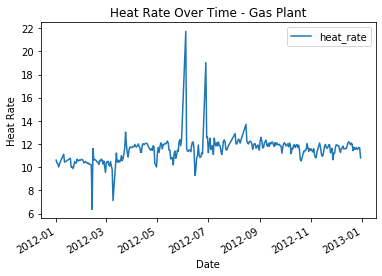

In [108]:
plant1 = plant[plant['orispl_unit']=='2840_3'] 

plant1.plot(x='date', y='heat_rate', style='-')  
plt.title('Heat Rate Over Time - Gas Plant')  
plt.xlabel('Date')
plt.ylabel('Heat Rate')

plt.show()

#### Impact of Demand on Emissions

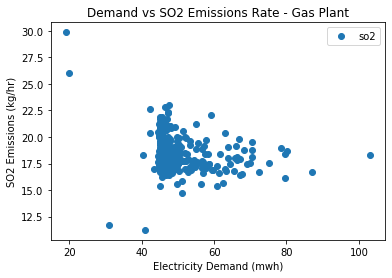

In [154]:
plant1.plot(x='mwh', y='so2', style='o')  
plt.title('Demand vs SO2 Emissions Rate - Gas Plant')  
plt.xlabel('Electricity Demand (mwh)')
plt.ylabel('SO2 Emissions (kg/hr)')

plt.show()

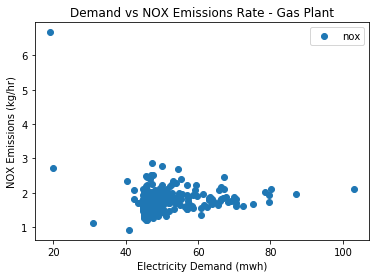

In [155]:
plant1.plot(x='mwh', y='nox', style='o')  
plt.title('Demand vs NOX Emissions Rate - Gas Plant')  
plt.xlabel('Electricity Demand (mwh)')
plt.ylabel('NOX Emissions (kg/hr)')

plt.show()

### Plant 2 - Coal

#### Heat Rate

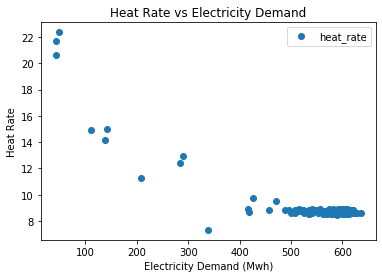

In [156]:
plant1 = plant[plant['orispl_unit']=='2828_1'] 

plant1.plot(x='mwh', y='heat_rate', style='o')  
plt.title('Heat Rate vs Electricity Demand')  
plt.xlabel('Electricity Demand (Mwh)')
plt.ylabel('Heat Rate')

plt.show()

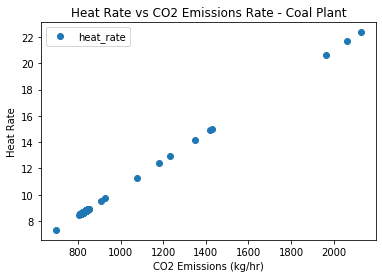

In [157]:
plant1.plot(x='co2', y='heat_rate', style='o')  
plt.title('Heat Rate vs CO2 Emissions Rate - Coal Plant')  
plt.xlabel('CO2 Emissions (kg/hr)')
plt.ylabel('Heat Rate')

plt.show()

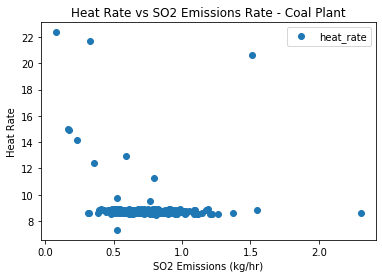

In [158]:
plant1.plot(x='so2', y='heat_rate', style='o')  
plt.title('Heat Rate vs SO2 Emissions Rate - Coal Plant')  
plt.xlabel('SO2 Emissions (kg/hr)')
plt.ylabel('Heat Rate')

plt.show()

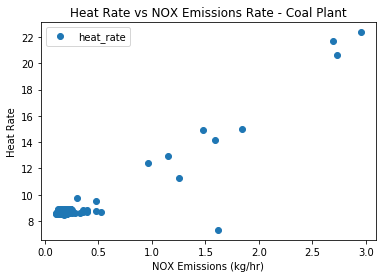

In [159]:
plant1.plot(x='nox', y='heat_rate', style='o')  
plt.title('Heat Rate vs NOX Emissions Rate - Coal Plant')  
plt.xlabel('NOX Emissions (kg/hr)')
plt.ylabel('Heat Rate')

plt.show()

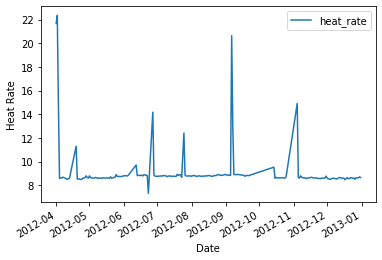

In [160]:
plant1.plot(x='date', y='heat_rate', style='-')  
plt.xlabel('Date')
plt.ylabel('Heat Rate')

plt.show()

#### Impact of Demand on Emissions

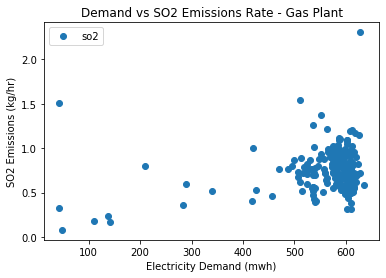

In [161]:
plant1.plot(x='mwh', y='so2', style='o')  
plt.title('Demand vs SO2 Emissions Rate - Gas Plant')  
plt.xlabel('Electricity Demand (mwh)')
plt.ylabel('SO2 Emissions (kg/hr)')

plt.show()

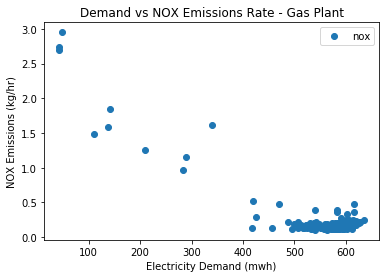

In [162]:
plant1.plot(x='mwh', y='nox', style='o')  
plt.title('Demand vs NOX Emissions Rate - Gas Plant')  
plt.xlabel('Electricity Demand (mwh)')
plt.ylabel('NOX Emissions (kg/hr)')

plt.show()

### Plant 3 - Oil

#### Heat Rate

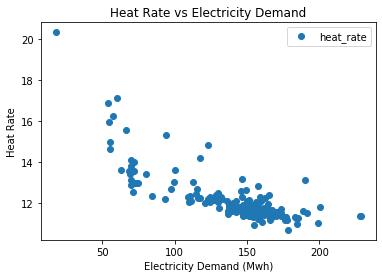

In [164]:
plant1 = plant[plant['orispl_unit']=='593_5'] 

plant1.plot(x='mwh', y='heat_rate', style='o')  
plt.title('Heat Rate vs Electricity Demand')  
plt.xlabel('Electricity Demand (Mwh)')
plt.ylabel('Heat Rate')

plt.show()

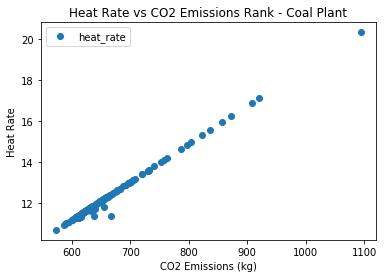

In [115]:
plant1.plot(x='co2', y='heat_rate', style='o')  
plt.title('Heat Rate vs CO2 Emissions Rate - Oil Plant')  
plt.xlabel('CO2 Emissions (kg)')
plt.ylabel('Heat Rate')

plt.show()

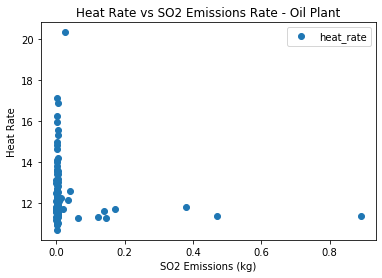

In [116]:
plant1.plot(x='so2', y='heat_rate', style='o')  
plt.title('Heat Rate vs SO2 Emissions Rate - Oil Plant')  
plt.xlabel('SO2 Emissions (kg)')
plt.ylabel('Heat Rate')

plt.show()

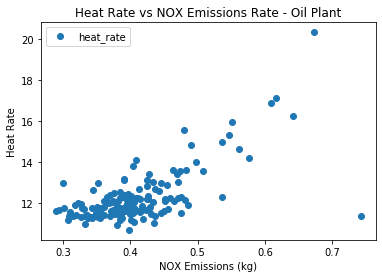

In [117]:
plant1.plot(x='nox', y='heat_rate', style='o')  
plt.title('Heat Rate vs NOX Emissions Rate - Oil Plant')  
plt.xlabel('NOX Emissions (kg)')
plt.ylabel('Heat Rate')

plt.show()

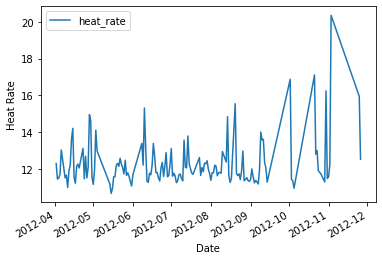

In [87]:
plant1 = plant[plant['orispl_unit']=='593_5'] 

plant1.plot(x='date', y='heat_rate', style='-')  
plt.xlabel('Date')
plt.ylabel('Heat Rate')

plt.show()

#### Impact of Demand on Emissions

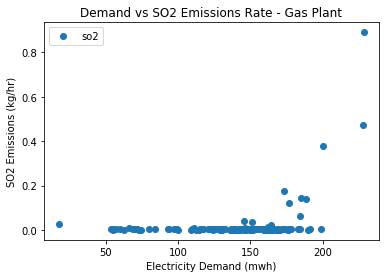

In [165]:
plant1.plot(x='mwh', y='so2', style='o')  
plt.title('Demand vs SO2 Emissions Rate - Gas Plant')  
plt.xlabel('Electricity Demand (mwh)')
plt.ylabel('SO2 Emissions (kg/hr)')

plt.show()

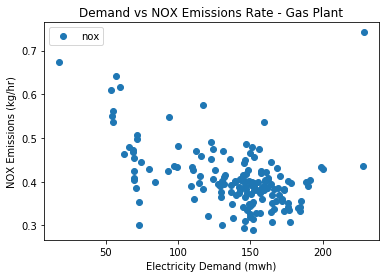

In [166]:
plant1.plot(x='mwh', y='nox', style='o')  
plt.title('Demand vs NOX Emissions Rate - Gas Plant')  
plt.xlabel('Electricity Demand (mwh)')
plt.ylabel('NOX Emissions (kg/hr)')

plt.show()

**CO2 vs Heat Rate Relationship**

In [134]:
df = df_orispl_unit.copy(deep=True)

df_gas = df.loc[df['fuel_type'] == 'gas'].drop(['fuel_type'], axis=1)
df_coal = df.loc[df['fuel_type'] == 'coal'].drop(['fuel_type'], axis=1)
df_oil = df.loc[df['fuel_type'] == 'oil'].drop(['fuel_type'], axis=1)

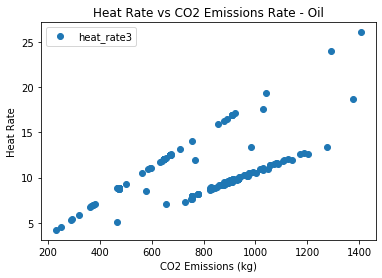

In [140]:
df.plot(x='co23', y='heat_rate3', style='o')  
plt.title('Heat Rate vs CO2 Emissions Rate - Oil')  
plt.xlabel('CO2 Emissions (kg)')
plt.ylabel('Heat Rate')

plt.show()

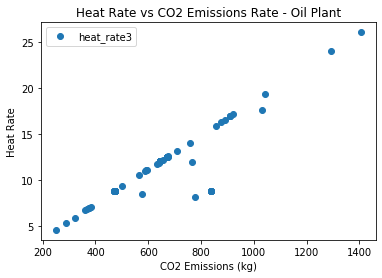

In [135]:
df_gas.plot(x='co23', y='heat_rate3', style='o')  
plt.title('Heat Rate vs CO2 Emissions Rate - Oil Plant')  
plt.xlabel('CO2 Emissions (kg)')
plt.ylabel('Heat Rate')

plt.show()

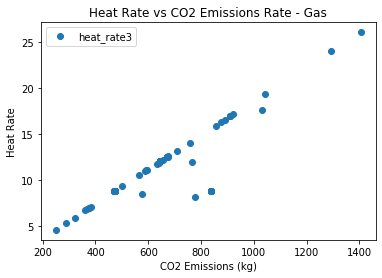

In [137]:
df_gas.plot(x='co23', y='heat_rate3', style='o')  
plt.title('Heat Rate vs CO2 Emissions Rate - Gas')  
plt.xlabel('CO2 Emissions (kg)')
plt.ylabel('Heat Rate')

plt.show()

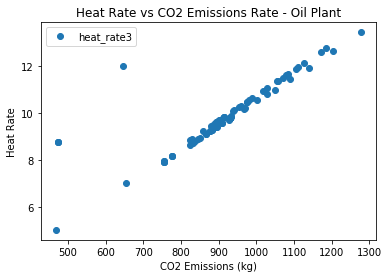

In [136]:
df_coal.plot(x='co23', y='heat_rate3', style='o')  
plt.title('Heat Rate vs CO2 Emissions Rate - Coal')  
plt.xlabel('CO2 Emissions (kg)')
plt.ylabel('Heat Rate')

plt.show()

### How much does production cost change over time?
- Production cost = heat rate * fuel price + variable operations and maintenance cost (VOM)

In [118]:
df_orispl_unit = pandas.read_csv('/home/amy/simple_dispatch/weekly/PJM_df.csv')

### Old weather stuff

Get plant data from egrid file. Save to a csv so I don't need to run this everytime

**Get a list of all relevant weather stations**

In [356]:
# Keep ones that are in the U.S. 
df_stations = pandas.read_csv('/home/amy/thesis/temperature/gsod-stations.csv')
df_stations = df_stations.dropna()
df_stations = df_stations.loc[df_stations['CTRY'] == "US"]

# Keep only stations that have data from 2012 - 2018
df_stations['BEGIN']= pandas.to_datetime(df_stations['BEGIN'], format="%Y%m%d") 
df_stations['END']= pandas.to_datetime(df_stations['END'], format="%Y%m%d") 
df_stations = df_stations[(df_stations['BEGIN'] <= '2012-1-1') & (df_stations['END'] >= '2012-12-31')]
df_stations.columns=['USAF', 'WBAN', 'name','country','state', 'ICAO', 'lat', 'lon', 'elev', 'begin', 'end']

df_stations.head()

,USAF,WBAN,name,country,state,ICAO,lat,lon,elev,begin,end
14474,690150,93121,TWENTY NINE PALMS,US,CA,KNXP,34.300,-116.167,625.1,1990-01-02,2020-03-02
15082,700001,26492,PORTAGE GLACIER,US,AK,PATO,60.785,-148.839,31.4,2006-01-01,2020-03-02
15084,700197,26558,SELAWIK,US,AK,PASK,66.600,-159.986,7.6,2006-01-01,2020-03-02
15086,700260,27502,W POST-WILL ROGERS MEMORIAL AIRPORT,US,AK,PABR,71.283,-156.782,9.5,1945-01-01,2020-03-02
15090,700300,27503,WAINWRIGHT AIRPORT,US,AK,PAWI,70.639,-159.995,9.1,1999-11-02,2020-03-02


**Match weather stations with egrid plant data**

In [365]:
df_data = df_data[(df_data.mwh >= 10.0) & (df_data.heat_rate <= 30.0)]    

df_cems_rounded = df_data.round()
df_stations_rounded = df_stations.round()
df_stations_rounded = df_stations_rounded.drop_duplicates(subset=['lat', 'lon'])

merged = pandas.merge(df_cems_rounded, df_stations_rounded, on=['lat','lon'], how='left', indicator='Exist')
print(merged['Exist'].value_counts(normalize=True) * 100)

# Drop ones that are only in one df, then use the station 
merged = merged.dropna()

both          97.297
left_only      2.703
right_only     0.000
Name: Exist, dtype: float64


In [367]:
# Reformat df to correspond to file storage in ftp 
df_stations.WBAN = df_stations.WBAN.astype(int)
df_stations.WBAN = df_stations.WBAN.astype(str)
df_stations.WBAN = df_stations.WBAN.str.zfill(5)

df_stations['station_id'] = df_stations.USAF + '-' + df_stations.WBAN

df_stations.head()

,USAF,WBAN,name,country,state,ICAO,lat,lon,elev,begin,end,station_id
14474,690150,93121,TWENTY NINE PALMS,US,CA,KNXP,34.300,-116.167,625.1,1990-01-02,2020-03-02,690150-93121
15082,700001,26492,PORTAGE GLACIER,US,AK,PATO,60.785,-148.839,31.4,2006-01-01,2020-03-02,700001-26492
15084,700197,26558,SELAWIK,US,AK,PASK,66.600,-159.986,7.6,2006-01-01,2020-03-02,700197-26558
15086,700260,27502,W POST-WILL ROGERS MEMORIAL AIRPORT,US,AK,PABR,71.283,-156.782,9.5,1945-01-01,2020-03-02,700260-27502
15090,700300,27503,WAINWRIGHT AIRPORT,US,AK,PAWI,70.639,-159.995,9.1,1999-11-02,2020-03-02,700300-27503


**Try using Plant: 3935_1 (coal) and Weather station: 720160-63884**
- Checked the location manually, they are pretty close

In [368]:
### Function from https://github.com/tagomatech/ETL/blob/master/gsod/gsod.py 
def getData(station, year):
    '''
    Get weather data from the internet as memory stream
    '''
    big_df = pandas.DataFrame()


    # Define URL
    url = 'http://www1.ncdc.noaa.gov/pub/data/gsod/' + str(year) + '/' + str(station) \
        + '-' + str(year) + '.op.gz'

    # Define data stream
    stream = requests.get(url)

    # Unzip on-the-fly
    decomp_bytes = gzip.decompress(stream.content)
    data = decomp_bytes.decode('utf-8').split('\n')

    '''
    Data manipulations and ordering
    '''
    # Remove start and end
    data.pop(0) # Remove first line header
    data.pop()  # Remove last element

    # Define lists
    (stn, wban, date, temp, temp_c, dewp, dewp_c,
     slp, slp_c, stp, stp_c, visib, visib_c,
     wdsp, wdsp_c, mxspd, gust, max, max_f, min, min_f,
     prcp, prcp_f, sndp, f, r, s, h, th, tr) = ([] for i in range(30))

    # Fill in lists
    for i in range(0, len(data)):
        stn.append(data[i][0:6])
        wban.append(data[i][7:12])
        date.append(data[i][14:22])         
        temp.append(data[i][25:30])
        dewp.append(data[i][36:41])
        slp.append(data[i][46:52])      # Mean sea level pressure
        stp.append(data[i][57:63])      # Mean station pressure
        visib.append(data[i][68:73])
        wdsp.append(data[i][78:83])
        mxspd.append(data[i][88:93])
        gust.append(data[i][95:100])
        max.append(data[i][103:108])
        min.append(data[i][111:116])
        prcp.append(data[i][118:123])
        sndp.append(data[i][125:130])   # Snow depth in inches to tenth
        f.append(data[i][132])          # Fog
        r.append(data[i][133])          # Rain or drizzle
        s.append(data[i][134])          # Snow or ice pallet
        h.append(data[i][135])          # Hail
        th.append(data[i][136])         # Thunder
        tr.append(data[i][137])         # Tornado or funnel cloud

    '''
    Replacements
    min_f & max_f
    blank   : explicit => e
    *       : derived => d
    '''
    #Create dataframe & cleanse data
    # Create intermediate matrix
    mat = np.matrix(data=[stn, wban, date, temp, dewp,
           slp, stp, visib,
           wdsp, mxspd, gust, max, min,
           prcp, sndp, f, r, s, h, th, tr]).T

    # Define header names
    headers = ['stn', 'wban', 'date', 'temp', 'dewp', 
    'slp', 'stp',  'visib', 
    'wdsp', 'mxspd', 'gust', 'max', 'min', 
    'prcp', 'sndp', 'f', 'r', 's', 'h', 'th', 'tr']

    # Set precision
    pandas.set_option('precision', 3)

    # Create dataframe from matrix object
    df = pandas.DataFrame(data=mat, columns=headers)

    # Replace missing values with NAs
    df = df.where(df != ' ', 9999.9)

    # Create station ids
    df['station_id'] = df['stn'].map(str) + '-' + df['wban'].map(str)
    df = df.drop(['stn', 'wban'], axis=1)

    # Convert to numeric
    df[['temp', 'dewp', 'slp', 'stp', 'visib', 'wdsp','mxspd',  'gust', 'max', 'min', 'prcp', 'sndp']] = df[['temp', 'dewp', 'slp', 'stp', 'visib', 'wdsp', 'mxspd', 'gust', 'max','min', 'prcp', 'sndp']].apply(pandas.to_numeric)
    
    # Replace missing weather data with NaNs
    df = df.replace(to_replace=[99.99, 99.9,999.9,9999.9], value=np.nan)

    # Convert to date format
    df['date'] = pandas.to_datetime(df['date'], format='%Y%m%d')

    big_df = pandas.concat([big_df, df])

    return big_df

In [369]:
weather_data = pandas.DataFrame()

year = 2012
try:
    weather_data = weather_data.append(getData(station=str('720160-63884'), year=str(year)))
except:
    print('no data')
    pass
weather_data

,date,temp,dewp,slp,stp,visib,wdsp,mxspd,gust,max,min,prcp,sndp,f,r,s,h,th,tr,station_id
0,2012-01-01,39.3,37.3,NaN,NaN,9.3,0.9,9.9,21.0,57.2,32.0,NaN,NaN,0,1,0,0,0,0,720160-63884
1,2012-01-02,34.5,22.3,NaN,NaN,9.2,4.8,9.9,22.9,44.6,26.6,NaN,NaN,0,0,1,0,0,0,720160-63884
2,2012-01-03,22.5,17.1,NaN,NaN,5.6,3.2,8.0,15.9,24.8,21.2,NaN,NaN,0,0,1,0,0,0,720160-63884
3,2012-01-04,23.3,15.3,NaN,NaN,10.0,0.2,4.1,NaN,42.8,12.2,0.0,NaN,0,0,0,0,0,0,720160-63884
4,2012-01-05,34.3,28.4,NaN,NaN,10.0,0.3,4.1,NaN,46.4,26.6,0.0,NaN,0,0,0,0,0,0,720160-63884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,2012-12-27,33.0,30.6,NaN,NaN,7.5,NaN,NaN,NaN,46.4,30.2,NaN,NaN,0,1,1,0,0,0,720160-63884
345,2012-12-28,32.7,28.7,NaN,NaN,10.0,NaN,NaN,NaN,41.0,30.2,0.0,NaN,0,0,0,0,0,0,720160-63884
346,2012-12-29,36.5,35.2,NaN,NaN,5.8,NaN,NaN,NaN,39.2,32.0,NaN,NaN,0,1,1,0,0,0,720160-63884
347,2012-12-30,28.9,25.7,NaN,NaN,5.8,NaN,NaN,NaN,32.0,23.0,NaN,NaN,0,0,1,0,0,0,720160-63884


In [370]:
plant = df_data[df_data['orispl_unit']=='3935_1'] 
cols = ['date', 'hour', 'mwh', 'heat_rate', 'co2', 'so2', 'nox', 'orispl_unit']
plant = plant[cols]
plant['date'] = pandas.to_datetime(plant['date'])

# separate the dfs
demand = plant[['date', 'mwh']]
plant_info = plant[['date', 'mwh', 'heat_rate', 'co2', 'so2', 'nox']]
demand['date'] = pandas.to_datetime(demand['date'])
plant_info['date'] = pandas.to_datetime(plant_info['date'])

# Aggregate by day: sum the demand, average the heat and emissions rates 
demand = demand.groupby('date').sum().reset_index()
plant_info = plant_info.groupby('date').mean().reset_index()

df = pandas.merge(weather_data, demand, on='date', how='left')
df = pandas.merge(weather_data, plant_info, on='date', how='inner')
df

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,date,temp,dewp,slp,stp,visib,wdsp,mxspd,gust,max,...,s,h,th,tr,station_id,mwh,heat_rate,co2,so2,nox
0,2012-01-01,39.3,37.3,NaN,NaN,9.3,0.9,9.9,21.0,57.2,...,0,0,0,0,720160-63884,510.083,9.060,861.985,0.020,0.194
1,2012-01-02,34.5,22.3,NaN,NaN,9.2,4.8,9.9,22.9,44.6,...,1,0,0,0,720160-63884,631.125,8.774,834.792,0.088,0.184
2,2012-01-03,22.5,17.1,NaN,NaN,5.6,3.2,8.0,15.9,24.8,...,1,0,0,0,720160-63884,741.167,8.584,816.715,0.157,0.166
3,2012-01-04,23.3,15.3,NaN,NaN,10.0,0.2,4.1,NaN,42.8,...,0,0,0,0,720160-63884,722.167,8.582,816.562,0.139,0.172
4,2012-01-05,34.3,28.4,NaN,NaN,10.0,0.3,4.1,NaN,46.4,...,0,0,0,0,720160-63884,668.833,8.699,827.682,0.126,0.180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2012-12-27,33.0,30.6,NaN,NaN,7.5,NaN,NaN,NaN,46.4,...,1,0,0,0,720160-63884,621.083,9.104,866.220,0.182,0.168
269,2012-12-28,32.7,28.7,NaN,NaN,10.0,NaN,NaN,NaN,41.0,...,0,0,0,0,720160-63884,619.708,9.153,870.893,0.236,0.173
270,2012-12-29,36.5,35.2,NaN,NaN,5.8,NaN,NaN,NaN,39.2,...,1,0,0,0,720160-63884,635.417,9.099,865.743,0.269,0.183
271,2012-12-30,28.9,25.7,NaN,NaN,5.8,NaN,NaN,NaN,32.0,...,1,0,0,0,720160-63884,629.958,9.194,874.745,0.229,0.180


In [371]:
# Remove columns with a lot of NaN
df = df.drop(columns = ['slp', 'stp', 'prcp', 'sndp', 'gust', 'th', 'tr', 'h', 'f'])

# Replace Nan with mean 
df = df.fillna(df.mean())

# Extract month, hour, and day from date columns
df['month'] = pandas.DatetimeIndex(df.date).month 
df['day'] = pandas.DatetimeIndex(df.date).day
df['year'] = pandas.DatetimeIndex(df.date).year

df

,date,temp,dewp,visib,wdsp,mxspd,max,min,r,s,station_id,mwh,heat_rate,co2,so2,nox,month,day,year
0,2012-01-01,39.3,37.3,9.3,0.900,9.900,57.2,32.0,1,0,720160-63884,510.083,9.060,861.985,0.020,0.194,1,1,2012
1,2012-01-02,34.5,22.3,9.2,4.800,9.900,44.6,26.6,0,1,720160-63884,631.125,8.774,834.792,0.088,0.184,1,2,2012
2,2012-01-03,22.5,17.1,5.6,3.200,8.000,24.8,21.2,0,1,720160-63884,741.167,8.584,816.715,0.157,0.166,1,3,2012
3,2012-01-04,23.3,15.3,10.0,0.200,4.100,42.8,12.2,0,0,720160-63884,722.167,8.582,816.562,0.139,0.172,1,4,2012
4,2012-01-05,34.3,28.4,10.0,0.300,4.100,46.4,26.6,0,0,720160-63884,668.833,8.699,827.682,0.126,0.180,1,5,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2012-12-27,33.0,30.6,7.5,1.072,6.085,46.4,30.2,1,1,720160-63884,621.083,9.104,866.220,0.182,0.168,12,27,2012
269,2012-12-28,32.7,28.7,10.0,1.072,6.085,41.0,30.2,0,0,720160-63884,619.708,9.153,870.893,0.236,0.173,12,28,2012
270,2012-12-29,36.5,35.2,5.8,1.072,6.085,39.2,32.0,1,1,720160-63884,635.417,9.099,865.743,0.269,0.183,12,29,2012
271,2012-12-30,28.9,25.7,5.8,1.072,6.085,32.0,23.0,0,1,720160-63884,629.958,9.194,874.745,0.229,0.180,12,30,2012


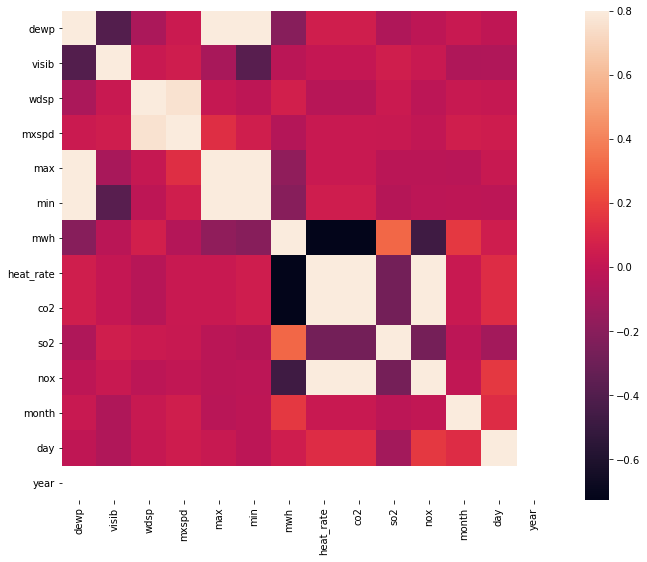

In [375]:
df = df.drop(columns=['date', 'station_id'])

# Remove temperature to keep max and min temp 
df = df.drop(columns=['temp'])

corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

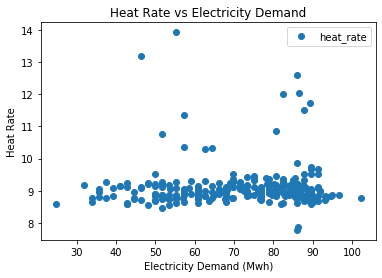

In [376]:
df.plot(x='max', y='heat_rate', style='o')  
plt.title('Heat Rate vs Electricity Demand')  
plt.xlabel('Electricity Demand (Mwh)')
plt.ylabel('Heat Rate')

plt.show()

### Read in data, save as csv

In [14]:
# # Get plant data for 2014
egrid_fname = '/home/amy/simple_dispatch/egrid2014_data.xlsx' 
df_plnt = pandas.read_excel(egrid_fname, 'PLNT14', skiprows=[0])

#geography
df_plnt = df_plnt[['ORISPL', 'BACODE', 'ISORTO', 'SUBRGN', 'LAT', 'LON', 'PLFUELCT']]
df_plnt.columns = ['orispl', 'ba', 'isorto', 'egrid', 'lat', 'lon', 'fuel']

df_plnt = df_plnt.loc[df_plnt['isorto'] == 'PJM']
df_plnt.to_csv('df_plnt.csv')

In [15]:
# Get data for 4 years for North Carolina 
df_data = pandas.DataFrame()
year = 2012

cems_folder = '/home/amy/MEFR/Marginal emissions factor data/CEMS/unzipped/' + str(year) + '/'
s = ['de', 'oh', 'in', 'wv']
df_cems = pandas.DataFrame()

for state in s: 
    for m in ['01','02','03','04','05','06','07','08','09','10','11', '12']:
        df_cems_add = pandas.read_csv(cems_folder + str(year) + state + m + '.csv')
        df_cems_add = df_cems_add[['ORISPL_CODE', 'UNITID', 'OP_DATE','OP_HOUR','GLOAD (MW)', 'SO2_MASS (lbs)', 'NOX_MASS (lbs)', 'CO2_MASS (tons)', 'HEAT_INPUT (mmBtu)']].dropna()
        df_cems_add.columns=['orispl', 'unit', 'date','hour','mwh', 'so2_tot', 'nox_tot', 'co2_tot', 'mmbtu']
        df_cems = pandas.concat([df_cems, df_cems_add])

#create the 'orispl_unit' column, which combines orispl and unit into a unique tag for each generation unit
df_cems['orispl_unit'] = df_cems['orispl'].map(str) + '_' + df_cems['unit'].map(str)

df_cems = df_cems.merge(df_plnt, how='left', on='orispl')  
df_cems = df_cems[df_cems['isorto']=='PJM'] 

#convert emissions to kg
df_cems.co2_tot = df_cems.co2_tot * 907.185 #tons to kg
df_cems.so2_tot = df_cems.so2_tot * 0.454 #lbs to kg
df_cems.nox_tot = df_cems.nox_tot * 0.454 #lbs to kg

#calculate the hourly heat and emissions rates. Later we will take the medians over each week to define the generators weekly heat and emissions rates.
df_cems['heat_rate'] = df_cems.mmbtu / df_cems.mwh
df_cems['co2'] = df_cems.co2_tot / df_cems.mwh
df_cems['so2'] = df_cems.so2_tot / df_cems.mwh
df_cems['nox'] = df_cems.nox_tot / df_cems.mwh
df_cems.replace([scipy.inf, -scipy.inf], scipy.nan, inplace=True) #don't want inf messing up median calculations

#drop any bogus data. For example, the smallest mmbtu we would expect to see is 25MW(smallest unit) * 0.4(smallest minimum output) * 6.0 (smallest heat rate) = 60 mmbtu. Any entries with less than 60 mmbtu fuel or less than 6.0 heat rate, let's get rid of that row of data.
df_cems = df_cems[(df_cems.heat_rate >= 6.0) & (df_cems.mmbtu >= 60)]
df_data = df_data.append(df_cems)

/home/amy/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10,12,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
from datetime import timedelta
year = 2012 
df_orispl_unit = df_data.copy(deep=True)
df_orispl_unit.date = df_orispl_unit.date.str.replace('/','-')
temp = pandas.DataFrame(df_orispl_unit.date.str.split('-').tolist(), columns=['month', 'day', 'year'], index=df_orispl_unit.index).astype(float)
df_orispl_unit['monthday'] = temp.year*10000 + temp.month*100 + temp.day
###
#loop through the weeks, slice the data, and find the average heat rates and emissions rates
#first, add a column 't' that says which week of the simulation we are in
df_orispl_unit['t'] = 52
for t in np.arange(52)+1:
    start = (datetime.strptime(str(year) + '-01-01', '%Y-%m-%d') + timedelta(days=7.05*(t-1)-1)).strftime('%Y-%m-%d') 
    end = (datetime.strptime(str(year) + '-01-01', '%Y-%m-%d') + timedelta(days=7.05*(t)-1)).strftime('%Y-%m-%d') 
    start_monthday = float(start[0:4])*10000 + float(start[5:7])*100 + float(start[8:])
    end_monthday = float(end[0:4])*10000 + float(end[5:7])*100 + float(end[8:])
    #slice the data for the days corresponding to the time series period, t
    df_orispl_unit.loc[(df_orispl_unit.monthday >= start_monthday) & (df_orispl_unit.monthday < end_monthday), 't'] = t 

In [17]:
#remove outlier emissions and heat rates. These happen at hours where a generator's output is very low (e.g. less than 10 MWh). To remove these, we will remove any datapoints where mwh < 10.0 and heat_rate < 30.0 (0.5% percentiles of the 2014 TRE data).
df_orispl_unit = df_orispl_unit[(df_orispl_unit.mwh >= 10.0) & (df_orispl_unit.heat_rate <= 30.0)]    

#aggregate by orispl_unit and t to get the heat rate, emissions rates, and capacity for each unit at each t
temp_2 = df_orispl_unit.groupby(['orispl_unit', 't'], as_index=False).agg('median')[['orispl_unit', 't', 'heat_rate', 'co2', 'so2', 'nox']].copy(deep=True)
temp_2['mw'] = df_orispl_unit.groupby(['orispl_unit', 't'], as_index=False).agg('max')['mwh'].copy(deep=True)
#condense df_orispl_unit down to where we just have 1 row for each unique orispl_unit
df_orispl_unit = df_orispl_unit.groupby('orispl_unit', as_index=False).agg('max')[['orispl_unit', 'orispl', 'ba', 'isorto', 'egrid', 'mwh']]
df_orispl_unit.rename(columns={'mwh':'mw'}, inplace=True)
for c in ['heat_rate', 'co2', 'so2', 'nox', 'mw']:
    temp_3 = temp_2.set_index(['orispl_unit', 't'])[c].unstack().reset_index()
    temp_3.columns = list(['orispl_unit']) + ([c + str(a) for a in scipy.arange(52)+1])
    
    #remove any outlier values in the 1st or 99th percentiles
    max_array = temp_3.copy().drop(columns='orispl_unit').quantile(0.99, axis=1) 
    min_array = temp_3.copy().drop(columns='orispl_unit').quantile(0.01, axis=1)
    
    median_array = temp_3.copy().drop(columns='orispl_unit').median(axis=1)
    for i in temp_3.index: 
        test = temp_3.drop(columns='orispl_unit').iloc[i]
        test[test > max_array[i]] = np.NaN
        test[test < min_array[i]] = np.NaN
        test = list(test) #had a hard time putting the results back into temp_3 without using a list
        #if the first entry in test is nan, we want to fill that with the median value so that we can use ffill later
        if math.isnan(test[0]):
            test[0] = median_array[i]
        test.insert(0, temp_3.iloc[i].orispl_unit)
        temp_3.iloc[i] = test
        
    #for any nan values (assuming these are offline generators without any output data), fill nans with a large heat_rate that will move the generator towards the end of the merit order and large-ish emissions rate, so if the generator is dispatched in the model it will jack up prices but emissions won't be heavily affected (note, previously I just replaced all nans with 99999, but I was concerned that this might lead to a few hours of the year with extremely high emissions numbers that threw off the data)
#     M = float(scipy.where(c=='heat_rate', 50.0, scipy.where(c=='co2', 1500.0, scipy.where(c=='so2', 4.0, scipy.where(c=='nox', 3.0, scipy.where(c=='mw', 0.0, 99.0)))))) #M here defines the heat rate and emissions data we will give to generators that were not online in the historical data
#     #if we are using hist_downtime, then replace scipy.NaN with M. That way offline generators can still be dispatched, but they will have high cost and high emissions.
#     if self.hist_downtime:
#         temp_3 = temp_3.fillna(M)

    #if we are not using hist_downtime, then use ffill to populate the scipy.NaN values. This allows us to use the last observed value for the generator to populate data that we don't have for it. For example, if generator G had a heat rate of 8.5 during time t-1, but we don't have data for time t, then we assume that generator G has a heat rate of 8.5 for t. When we do this, we can begin to include generators that might be available for dispatch but were not turned on because prices were too low. However, we also remove any chance of capturing legitimate maintenance downtime that would impact the historical data. So, for validation purposes, we probably want to have hist_downtime = True. For future scenario analysis, we probably want to have hist_downtime = False.
    temp_3 = temp_3.fillna(method='ffill')  
    temp_3.iloc[0] = temp_3.iloc[0].fillna(method='ffill') #for some reason the first row was not doing fillna(ffill)
    #merge temp_3 with df_orispl_unit. Now we have weekly heat rates, emissions rates, and capacities for each generator. These values depend on whether we are including hist_downtime
    df_orispl_unit = df_orispl_unit.merge(temp_3, on='orispl_unit', how='left')

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  if sys.path[0] == '':


In [18]:
df_orispl_unit.to_csv('heat_rate.csv')

In [19]:
#merge df_orispl_unit into df. Now we have a dataframe with weekly heat rate and emissions rates for any plants in CEMS with that data. There will be some nan values in df for those weekly columns (e.g. 'heat_rate1', 'co223', etc. that we will want to fill with annual averages from eGrid for now
orispl_units_egrid = df.orispl_unit.unique()
orispl_units_cems = df_orispl_unit.orispl_unit.unique()
df_leftovers = df[df.orispl_unit.isin(scipy.setdiff1d(orispl_units_egrid, orispl_units_cems))]

NameError: name 'df' is not defined